In [1]:
%reset
#.master('spark://10.64.22.198:7077') \
import pyspark.sql
session = pyspark.sql.SparkSession.builder \
    .master('spark://10.64.22.198:7077') \
    .appName("Zpeak_shoh") \
    .config('spark.jars.packages','org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
    .config('spark.driver.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.executor.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('py-files','helper.py') \
    .getOrCreate()
    
#sc = session.sparkContext
sqlContext = session

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Loading NanoAod root files using spark-root package

Loading the nanoaod root file serving from cern public eos, and load the tree in dedicated TDirectory in the root file.

In [2]:
from pyspark.sql.functions import lit
from samples import *
from __future__ import division

DFList = [] # will contain six dataframe from six processes with added xsec, eff, kfactor, weight, samples

for s in samples:
    print s
    #dsPath = "hdfs://10.64.22.72:9000/"+BASE+samples[s]['filename']
    dsPath = "root://eospublic.cern.ch//eos/opstest/cmspd-bigdata/"+samples[s]['filename']
    
    tempDF = sqlContext.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath)\
                .withColumn("proc_xsec", lit(samples[s]['xsec']))\
                .withColumn("proc_eff", lit(samples[s]['eff']))\
                .withColumn("proc_kfactor", lit(samples[s]['kfactor']))\
                .withColumn("proc_weight", lit(samples[s]['weight']))\
                .withColumn("proc_sample", lit(s))
    nev = tempDF.count()
    #nev = 1
    if samples[s]['xsec'] == None: # Data       
        DFList.append([tempDF.withColumn("proc_nevents",lit(nev))])        
    else: # MC
        samples[s]['weight'] = ( samples[s]['xsec'] * samples[s]['eff'] * samples[s]['kfactor'] * (LUMI / nev))
        DFList.append([tempDF.withColumn("proc_nevents",lit(nev))])        

print "Number of element:"
print "DFList size =", len(DFList)
#print "Number of columns:"
#print "DFList[0][0] =", len(DFList[0][0].columns)
#print "DFList[0][0] =", len(DFList[1][0].columns)
#print "DFList[1][0] =", len(DFList[2][0].columns)
#print "DFList[2][0] =", len(DFList[3][0].columns)
#print "DFList[3][0] =", len(DFList[4][0].columns)
#print "DFList[4][0] =", len(DFList[5][0].columns)

TT
WW
SingleMuon
ZZ
DYJetsToLL
WZ
Number of element:
DFList size = 6


In [3]:
from pyspark.sql.functions import lit
from samples import *
from __future__ import division

DFList = [] # will contain six dataframe from six processes with added xsec, eff, kfactor, weight, samples

for s in samples:
    print s
    #dsPath = "hdfs://10.64.22.72:9000/"+BASE+samples[s]['filename']
    dsPath = "root://eospublic.cern.ch//eos/opstest/cmspd-bigdata/"+samples[s]['filename']
    
    tempDF = sqlContext.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath)\
                .withColumn("proc_xsec", lit(samples[s]['xsec']))\
                .withColumn("proc_eff", lit(samples[s]['eff']))\
                .withColumn("proc_kfactor", lit(samples[s]['kfactor']))\
                .withColumn("proc_weight", lit(samples[s]['weight']))\
                .withColumn("proc_sample", lit(s))
    nev = tempDF.count()
    #nev = 1
    if samples[s]['xsec'] == None: # Data       
        DFList.append([tempDF.withColumn("proc_nevents",lit(nev))])        
    else: # MC
        samples[s]['weight'] = ( samples[s]['xsec'] * samples[s]['eff'] * samples[s]['kfactor'] * (LUMI / nev))
        DFList.append([tempDF.withColumn("proc_nevents",lit(nev))])        

print "Number of element:"
print "DFList size =", len(DFList)
print "Number of columns:"
print "DFList[0][0] =", len(DFList[0][0].columns)
print "DFList[0][0] =", len(DFList[1][0].columns)
print "DFList[1][0] =", len(DFList[2][0].columns)
print "DFList[2][0] =", len(DFList[3][0].columns)
print "DFList[3][0] =", len(DFList[4][0].columns)
print "DFList[4][0] =", len(DFList[5][0].columns)

TT
WW
SingleMuon
ZZ
DYJetsToLL
WZ
Number of element:
DFList size = 6
Number of columns:
DFList[0][0] = 979
DFList[0][0] = 964
DFList[1][0] = 869
DFList[2][0] = 964
DFList[3][0] = 979
DFList[4][0] = 964


# Reduces columns and Concatenates dataframes

Select interested attributes (kinematics of a physics object), and concatenate all dataframes into one gaint dataframe for ease of interpretation.

In [4]:
header = list(DFList[0][0].columns) #infer the column header from one of the dataframe
globalAttr = [g for g in header if 'proc_' in g]
muonAttr = [muon for muon in header if 'Muon' in muon and 'genPart' not in muon]
jetAttr = [jet for jet in header if 'Jet' in jet and 'HLT' not in jet]
electronAttr = [electron for electron in header if 'Electron' in electron]
Attributes = muonAttr + globalAttr
DF = None
if DFList:
    DF = DFList[0][0].select(Attributes)
    for x in DFList[1:]:
        DF = DF.union(x[0].select(Attributes))
    print "Partitions:  %d" % DF.rdd.getNumPartitions()

Partitions:  6


In [5]:
print "Inspect gaint dataframe"
for i in ["TT","DYJetsToLL","ZZ","WZ","WW","SingleMuon"]:
    DF.select('proc_sample','proc_weight','proc_xsec','proc_nevents').filter(DF.proc_sample.like("%s"%i)).show(3)

Inspect gaint dataframe
+-----------+-------------+---------+------------+
|proc_sample|  proc_weight|proc_xsec|proc_nevents|
+-----------+-------------+---------+------------+
|         TT|78.1522677366|   831.76|      382077|
|         TT|78.1522677366|   831.76|      382077|
|         TT|78.1522677366|   831.76|      382077|
+-----------+-------------+---------+------------+
only showing top 3 rows

+-----------+-------------+---------+------------+
|proc_sample|  proc_weight|proc_xsec|proc_nevents|
+-----------+-------------+---------+------------+
| DYJetsToLL|376.467123811|   5765.4|      549790|
| DYJetsToLL|376.467123811|   5765.4|      549790|
| DYJetsToLL|376.467123811|   5765.4|      549790|
+-----------+-------------+---------+------------+
only showing top 3 rows

+-----------+-------------+---------+------------+
|proc_sample|  proc_weight|proc_xsec|proc_nevents|
+-----------+-------------+---------+------------+
|         ZZ|1.24116931587|     16.6|      480144|
|       

# User Defined Function Definition and helper function

User Defined Function (UDF) is a function passes row by row to compute derived quantity such as invaraint mass of two physics objects involving multiple column. Helper function defined to facilitate event selection (using spark feature such as filter instead of python defined function (thanks to NANOAOD structure!))

In [6]:
from pyspark.sql.types import *

schema = StructType([
    StructField("pass", BooleanType(), False), # True if filled / False if default(empty) 
    StructField("ss", BooleanType(), False), # same sign?
    StructField("mass", FloatType(), False), # Z mass
    StructField("pt", FloatType(), False), # Z pt
    StructField("eta", FloatType(), False), # Z eta
    StructField("phi", FloatType(), False), # Z phi
    StructField("dPhi", FloatType(), False), # mu1,mu2 DeltaPhi
    StructField("dR", FloatType(), False), # mu1,mu2 DeltaR
    StructField("dEta", FloatType(), False), # mu1,mu2 DeltaEta
    
    StructField("mu1_pt", FloatType(), False), # leading mu pT 
    StructField("mu2_pt", FloatType(), False), # sub-leading mu pT 
    StructField("mu1_eta", FloatType(), False), # leading mu eta
    StructField("mu2_eta", FloatType(), False), # sub-leading mu eta
    StructField("mu1_phi", FloatType(), False), # leading mu phi
    StructField("mu2_phi", FloatType(), False), # sub-leading mu phi
    #StructField("mu1_charge", FloatType(), False), # leading mu charge 
    #StructField("mu2_charge", FloatType(), False), # sub-leading mu charge
])


In [7]:
#Jacopo's helper functions
def deltaPhi(phi1,phi2):
    ## Catch if being called with two objects
    if type(phi1) != float and type(phi1) != int:
        phi1 = phi1.phi
    if type(phi2) != float and type(phi2) != int:
        phi2 = phi2.phi
    ## Otherwise
    dphi = (phi1-phi2)
    while dphi >  pi: dphi -= 2*pi
    while dphi < -pi: dphi += 2*pi
    return dphi

def deltaR(eta1,phi1,eta2=None,phi2=None):
    ## catch if called with objects
    if eta2 == None:
        return deltaR(eta1.eta,eta1.phi,phi1.eta,phi1.phi)
    ## otherwise
    return hypot(eta1-eta2, deltaPhi(phi1,phi2))

def invMass(pt1,pt2, eta1, eta2, phi1, phi2, mass1, mass2):
    
        theta1 = 2.0*atan(exp(-eta1))
        px1 = pt1 * cos(phi1)
        py1 = pt1 * sin(phi1)
        pz1 = pt1 / tan(theta1)
        E1 = sqrt(px1**2 + py1**2 + pz1**2 + mass1**2)
        
        theta2 = 2.0*atan(exp(-eta2))
        px2 = pt2 * cos(phi2)
        py2 = pt2 * sin(phi2)
        pz2 = pt2 / tan(theta2)
        E2 = sqrt(px2**2 + py2**2 + pz2**2 + mass2**2)
        
        themass = sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
        thept = sqrt((px1 + px2)**2 + (py1 + py2)**2)
        thetheta = atan( thept / (pz1 + pz2) )        
        theeta = 0.5*log( (sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)+(pz1 + pz2))/(sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)-(pz1 + pz2)) )
        thephi = asin((py1 + py2)/thept)
        
        delPhi = deltaPhi(phi1,phi2)
        delR = deltaR(eta1,phi1,eta2,phi2)
        delEta = eta1-eta2
        
        return (
                themass, thept, theeta, thephi,
                delPhi, delR, delEta
               )
#########

#https://test-cms-nanoaod-integration.web.cern.ch/integration/master/mc80X_doc.html
from math import *
def invariantMass(pt,eta,phi,mass,charge,tightid):
    MLL = ( False,False,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 , 0.0, 0.0,  0.0, 0.0,  0.0, 0.0 )
    
    """
    Perform muon selection:
      pT > 30
      abs(eta) < 2.1
      80GeV < DiMuonInvMass < 100GeV
      tightId muon
      N(mu) == 2
    """
    
    if len(pt) < 2:
        return MLL
    
    #Identify muon candidate
    leadingIdx = None
    trailingIdx = None
 
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.1 and tightid[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.1 and tightid[idx]:
                trailingIdx = idx
        else:
            if pt[idx] > 30 and abs(eta[idx]) < 2.1 and tightid[idx]:
                return MLL
            
    # Once we have the candidate, compute Invariant mass
    if leadingIdx != None and trailingIdx != None:
        #print "Candidate found"
        sameSign= ((charge[leadingIdx] * charge[trailingIdx]) > 0)
        dimuInvMass = (True, sameSign,) + \
        invMass(pt[leadingIdx], pt[trailingIdx],
                                eta[leadingIdx], eta[trailingIdx],
                                phi[leadingIdx], phi[trailingIdx],
                                mass[leadingIdx], mass[trailingIdx])
        #append candidate kinematics's
        dimuInvMass = dimuInvMass+ ( pt[leadingIdx], pt[trailingIdx],
                                     eta[leadingIdx], eta[trailingIdx],
                                     phi[leadingIdx], phi[trailingIdx]
                                   )
        return dimuInvMass
    else:
        # if N(mu) != 2
        return MLL
    

# Test the UDF

In [8]:
#test helper function
#invMass(pt1,pt2, eta1, eta2, phi1, phi2, mass1, mass2)
print invMass(95.00175, 35.536867,0.79174805, 1.07,-1.0014648, 0.21,0.4, 0.4)

#invariantMass(pt,eta,phi,mass,charge,tightid)
print invariantMass([95.00175],[0.79174805, 1.07],[-1.0014648, 0.21],[0.4, 0.4],[-1, 1],["true", "true"])

(68.12910614340414, 112.5281196536678, 0.981381526514867, -0.701345090742176, -1.2114648, 1.2430088934990942, -0.27825195)
(False, False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


# Computing the invaraince mass of two lepton 

Deploying the UDF to take kinemtaics variables of muons, constructing TLorenztVecotr on the fly and append a new column to reduced table (Muon object selection)

In [9]:
from pyspark.sql.functions import udf
MllUDF = udf(invariantMass,schema)

DF = DF.withColumn('Zparticle',MllUDF("Muon_pt","Muon_eta","Muon_phi","Muon_mass","Muon_charge","Muon_tightId"))

for i in ["TT","DYJetsToLL","ZZ","WZ","WW","SingleMuon"]:
    DF.select('proc_sample','Zparticle','proc_weight').filter(DF.proc_sample.like("%s"%i)).filter("Zparticle.pass").show(3)

+-----------+--------------------+-------------+
|proc_sample|           Zparticle|  proc_weight|
+-----------+--------------------+-------------+
|         TT|[true,false,144.8...|78.1522677366|
|         TT|[true,false,71.81...|78.1522677366|
|         TT|[true,true,108.34...|78.1522677366|
+-----------+--------------------+-------------+
only showing top 3 rows

+-----------+--------------------+-------------+
|proc_sample|           Zparticle|  proc_weight|
+-----------+--------------------+-------------+
| DYJetsToLL|[true,false,92.16...|376.467123811|
| DYJetsToLL|[true,false,78.37...|376.467123811|
| DYJetsToLL|[true,false,88.75...|376.467123811|
+-----------+--------------------+-------------+
only showing top 3 rows

+-----------+--------------------+-------------+
|proc_sample|           Zparticle|  proc_weight|
+-----------+--------------------+-------------+
|         ZZ|[true,false,80.83...|1.24116931587|
|         ZZ|[true,false,102.3...|1.24116931587|
|         ZZ|[true,

In [10]:
DF = DF.where("Zparticle.pass == True")
DF = DF.cache()

for i in ["TT"]:
    DF.select('proc_sample','Zparticle.mu1_pt','Zparticle.mu2_pt','Muon_pt','proc_weight').filter(DF.proc_sample.like("%s" %i)).show(3)

+-----------+---------+---------+--------------------+-------------+
|proc_sample|   mu1_pt|   mu2_pt|             Muon_pt|  proc_weight|
+-----------+---------+---------+--------------------+-------------+
|         TT|135.60971| 49.35242|[135.60971, 49.35...|78.1522677366|
|         TT| 86.59694|30.364235|[86.59694, 30.364...|78.1522677366|
|         TT| 38.90641|33.944725|[38.90641, 33.944...|78.1522677366|
+-----------+---------+---------+--------------------+-------------+
only showing top 3 rows



# Plotting the Zpeak mass

In [11]:
# Load libraries, amp up passMuDF with histogrammar
%matplotlib inline
import matplotlib.pyplot as plt
import histogrammar as hg
import histogrammar.sparksql
hg.sparksql.addMethods(DF)

# Monkey-patch histogrammar to fix a bug
def x(self, jvm, converter):
    return converter.Select(self.quantity.asSparkSQL(), self.cut._sparksql(jvm, converter))
hg.Select._sparksql = x

In [12]:
plots = hg.UntypedLabel(
    # Count events (both raw and weighted)
    nRawEvents = hg.Sum(lit(1.0)),
    nEvents = hg.Sum(DF['proc_weight']),
    # Make some regular "histograms" of muon pT
    LeadRawPt = hg.Bin(50, 0, 150, DF['Zparticle.mu1_pt']),
    LeadPt = hg.Bin(50, 0, 150, DF['Zparticle.mu1_pt'], hg.Sum(DF['proc_weight'])),
    SecondPt = hg.Bin(50, 0, 150, DF['Zparticle.mu2_pt'], hg.Sum(DF['proc_weight'])),
    MLLMass = hg.Bin(50, 0, 150, DF['Zparticle.mass'], hg.Sum(DF['proc_weight'])),
    # Let's make an additional cut for only same-sign events
    ssCut = hg.Select(
        DF['Zparticle.ss'] == True,
        # .. and count them
        hg.Sum(DF['proc_weight']),
    ),
)

In [13]:
# Make a set of histograms per-sample
bulkHisto = hg.Categorize(quantity = DF["proc_sample"], value = plots)

In [14]:
# Fill from spark -- this is needed if you do a hg.Categorize (static) instead of a passMuDF.Categorize (the class method)
bulkHisto.fillsparksql(df=DF)

In [26]:
# Output some event counts as a result of cuts
# ... something is off with my WJets input files
sumEvents = 0.0
sumRawEvents = 0.0
print "Sample  Raw  Weighted"
for sample in bulkHisto.bins:
    if sample == "SingleMuon":
        continue
    events = bulkHisto(sample)('nEvents').sum
    rawEvents = bulkHisto(sample)('nRawEvents').sum
    print "%11s   %9.1f  % 11.1f" % (sample, rawEvents, events)
    sumEvents += float(events)
    sumRawEvents += float(rawEvents)

print "=" * 36
print "    Sum(MC)  % 9.1f  % 11.1f" % (sumRawEvents, sumEvents)
print "       Data % 9.1f  % 11.1f" % (bulkHisto('SingleMuon')('nRawEvents').sum, bulkHisto('SingleMuon')('nEvents').sum)

Sample  Raw  Weighted
         TT      3019.0     235941.7
         WW       985.0      12028.5
         ZZ      9265.0      11499.4
 DYJetsToLL     43465.0   16363143.5
         WZ      4282.0      17110.7
    Sum(MC)    61016.0   16639723.9
       Data    9247.0       9247.0


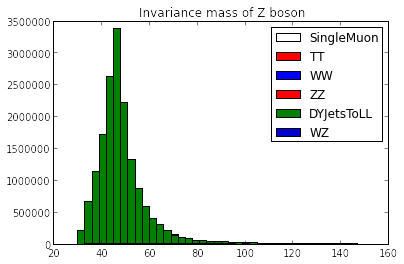

In [28]:
import numpy as np
ax = plt.gca()
#MLLMass, LeadRawPt
var='LeadPt'
oneHisto = bulkHisto("SingleMuon")('%s'%var)
num_bins = len(oneHisto.values)
edges = np.linspace(oneHisto.low, oneHisto.high, num_bins + 1)

width = (oneHisto.high - oneHisto.low) / num_bins

bot = None
leg = []
plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.sum for x in bulkHisto(k)('%s'%var).values]   
    if not bot:
        bot = [0 for x in range(len(plotVals[k]))]
    leg.append((k, ax.bar(edges[:-1], plotVals[k], bottom=bot, width=width, color=samples[k]['color'])))
    bot = [bot[x] + plotVals[k][x] for x in range(len(plotVals[k]))]
    
plotVals['SingleMuon'] = [x.sum for x in bulkHisto('SingleMuon')('%s'%var).values]
leg.insert(0, ('SingleMuon', ax.bar(edges[:-1], plotVals['SingleMuon'], width=width, color='black', fill=False)))
ax.legend([x[1] for x in leg], [x[0] for x in leg])
ax.set_title("Invariance mass of Z boson")

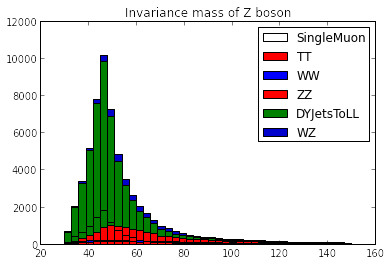

In [35]:
ax = plt.gca()
#MLLMass, LeadRawPt
var='LeadRawPt'
oneHisto = bulkHisto("SingleMuon")('%s'%var)
num_bins = len(oneHisto.values)
edges = np.linspace(oneHisto.low, oneHisto.high, num_bins + 1)

width = (oneHisto.high - oneHisto.low) / num_bins

bot = None
leg = []
plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.toJson()['data'] for x in bulkHisto(k)('%s'%var).values]   
    if not bot:
        bot = [0 for x in range(len(plotVals[k]))]
    leg.append((k, ax.bar(edges[:-1], plotVals[k], bottom=bot, width=width, color=samples[k]['color'])))
    bot = [bot[x] + plotVals[k][x] for x in range(len(plotVals[k]))]
    
plotVals['SingleMuon'] = [x.toJson()['data'] for x in bulkHisto('SingleMuon')('%s'%var).values]
leg.insert(0, ('SingleMuon', ax.bar(edges[:-1], plotVals['SingleMuon'], width=width, color='black', fill=False)))
ax.legend([x[1] for x in leg], [x[0] for x in leg])
ax.set_title("Invariance mass of Z boson")

In [ ]:
#test = np.random.randn(10, 3)
#print test
import seaborn as sns

fig, axes = plt.subplots()
ax1 = axes

array = np.ndarray((len(plotVals), len(plotVals.values()[0])))

for index, val in enumerate(plotVals.values()):
    array[index] = val
    
for j in plotVals:
    ax = sns.distplot(plotVals[j])
                      

